### University of Washington: Machine Learning and Statistics 

# Lecture 13: Convolutional and Recurrent Neural Networks

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 9.8.4
- [astroML website](https://www.astroml.org/index.html)
- [Deep Learning](https://www.deeplearningbook.org/) by Goodfellow, Bengio, and Courville, Chapters 9 & 10 (free to read online!)
- [Introduction to (Deep) Neural Networks](https://github.com/AstroHackWeek/AstroHackWeek2020/blob/master/machinelearning-2/astrohackweek_2020_neural_networks.ipynb) by Kyle Boone @ AstroHackWeek 2020 ([recording](https://www.youtube.com/watch?v=2Lpig1WxadU))
- [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/) and [Working with RNNs](https://keras.io/guides/working_with_rnns/) from the `keras` documentation
- [Conv Nets: A Modular Perspective](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) and [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and associated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of astroML

In [1]:
pip install --pre -U astroml

  Using cached astroML-1.0.2-py3-none-any.whl (134 kB)
  Attempting uninstall: astroml
    Found existing installation: astroML 0.4.1
    Uninstalling astroML-0.4.1:
      Successfully uninstalled astroML-0.4.1
Note: you may need to restart the kernel to use updated packages.


We'll also need to update `tensorflow` to the latest version:

In [2]:
pip install -U tensorflow

  Using cached tensorflow-2.8.0-cp39-cp39-manylinux2010_x86_64.whl (497.6 MB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached libclang-13.0.0-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.3
    Uninstalling tensorflow-2.4.3:
      Successfully uninstalled tensorflow-2.4.3
Note: you may need to restart the kerne

Run this cell to confirm you've got `tensorflow` version 2.8.0 (you may have to restart the kernel). If you're on the class JupyterHub, you can ignore the `cudart` warning because we're not using a GPU.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2022-02-27 09:35:46.907029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-27 09:35:46.907104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0


In [4]:
import numpy as np

from astroML.datasets import fetch_sdss_galaxy_images, fetch_LINEAR_sample, fetch_LINEAR_geneva
from astroML.utils import split_samples

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.gaussian_process import GaussianProcessRegressor

from tqdm import tqdm

## Classifying Images with Convolutional Neural Networks

CNNs are useful for handling image data - to demonstrate CNNs, we will work with a set of jpg galaxy images from the SDSS that have been classified as spiral or elliptical by Fischer et al. (2018) and Nair & Abraham (2010). Each image is 69 x 69 pixels and has three **channels** (R, G, and B). Conveniently, the images are already normalized to have minimum values of 0 and maximum values of 1.

In [5]:
images, labels = fetch_sdss_galaxy_images()
print(images.shape)
print(labels.shape)

print(np.min(images), np.max(images))

(1000, 69, 69, 3)
(1000,)
0.0 1.0


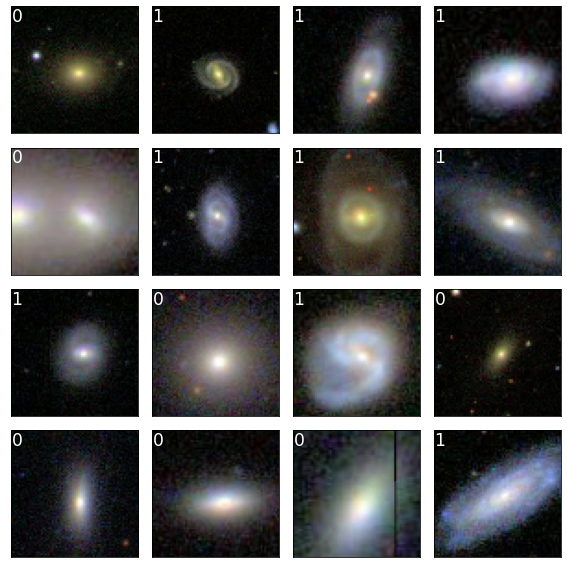

In [6]:
n = 4
plt.figure(figsize=(8,8))
for i in range(n):
    for j in range(n):
        k = i*4 + j
        plt.subplot(n, n, k + 1)
        plt.imshow(images[k])
        plt.xticks([])
        plt.yticks([])
        plt.text(0, 0, '%i' % labels[k], c='w', va='top', fontsize='xx-large')
plt.tight_layout()
plt.show()

In [7]:
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(images, labels, [0.8, 0.1, 0.1], random_state=0)

### Convolutional Layers

Unlike a fully connected layer where every neuron is connected to every neuron in the previous layer, in a **convolutional layer** neurons are only connected to *spatially nearby* neurons from the previous layer. In addition, the weights of these connections are spatially invariant - the connection weights only depend on the relative positions of the two neurons, not their absolute positions. In other words, the activations of the neurons in a convolutional layer are the result of convolving the activations of the previous layer with a **filter**/**kernel** (ie. weights for different relative positions) and then applying the activation function. The weights in the filter and the bias of the activation function are parameters to be learned. In practice, a convolutional layer will have multiple independent filters - in keras, `Conv2D(filters, kernel_size)` creates a 2D convolutional layer with `filters` independent filters that are each `kernel_size`x`kernel_size` pixels large. In our example, the first convolutional layer has 8 filters and uses a 3x3 kernel - because `padding='same'` pads the image with zeros, the convolution gives us an image of the same size as the input, 69x69 pixels.

<img src="http://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv-9-Conv2-XY.png" width="50%"/>

from [Conv Nets: A Modular Perspective](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) by Christopher Olah

Fully connected layers involving all the pixels of an image would quickly add many weights and biases to fit - convolutional layers drastically reduce the number of weights while maintaining performance by taking advantage of translation invariance. A filter will pick up a pattern, no matter where in the image it appears.

When training deep CNNs, **max pooling** is often used to shrink the size of a layer before applying another convolution. `MaxPooling2D(pool_size)` simply groups the neurons into non-overlapping pools of `pool_size`x`pool_size` pixels, and returns the maximum value for each pool, shrinking the image by a factor of `pool_size` in each dimension. If a filter picks up on the presence of some pattern and has high activation, max pooling maintains that high activation but just reduces the spatial resolution. This pooling happens independently for each filter, giving us 8 images of 34x34 pixels each. A common pattern in CNNs is to use max pooling after each layer to reduce the image size, but possibly increase the number of filters in the next layer.

To connect the final convolutional layer to our output layer, we `Flatten()` our 32 2x2 images into a 128 element array, which can then be connected via a fully connected layer to our one output neuron. Libraries like `keras` can take advantage of the fact that GPUs are great at convolutions, if you have a GPU.

<img src="http://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv-9-Conv2Max2Conv2.png" width="50%" />

from [Conv Nets: A Modular Perspective](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) by Christopher Olah

### Regularization with Dropout

Even with using convolutional layers to reduce the number of parameters, we still have over 33K parameters in our neural network. To help prevent overfitting to the training set, we will use some **dropout** layers. `Dropout(rate)` creates a layer that mimics the previous layer's activations, but will output zero for a fraction `rate` of the neurons. A different set of neurons will be randomly chosen at each training step, encouraging the network to learn more robust patterns that are not as drastically affected by individual neurons. After training, no dropout will occur.

In [8]:
model = keras.Sequential([
    keras.Input(shape=images.shape[1:]),
    
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
            
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 16)        0

2022-02-27 09:36:01.613531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-27 09:36:01.613597: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-27 09:36:01.613626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-sportill): /proc/driver/nvidia/version does not exist
2022-02-27 09:36:01.614023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Because this is a binary classification problem, we'll use the `BinaryCrossentropy` loss function. Both classes are well-represented, so we'll keep track of the overall `BinaryAccuracy` - how many classifications are correct.

In [9]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)

We'll use our usual `EarlyStopping` callback, as well as `ModelCheckpoint`. The validation loss of our model might worsen before `EarlyStopping` stops training, so `ModelCheckpoint` will keep track of whether the current epoch has the best validation loss so far, and save the network to disk if it does.

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    ),
    keras.callbacks.ModelCheckpoint("best_cnn",
        monitor='val_loss',
        verbose=0,
        save_best_only=True)
]

### Data Augmentation
**Data augmentation** is common when dealing with image data. If it makes sense for our classifier to be invariant to rotations, flips, and slight shifts and zooms, we can apply these transformations to the images in our training set. `ImageDataGenerator` will do this automatically during training, as `flow(X_train, y_train, batch_size=128)` will return batches of 128, where `y_train` is unchanged, but `X_train` has had different transformations applied.

In [11]:
datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75, 1.3])

In [12]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.6978 - binary_accuracy: 0.5125

2022-02-27 09:36:06.610362: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_cnn/assets
7/7 [==============================] - 6s 736ms/step - loss: 0.6978 - binary_accuracy: 0.5125 - val_loss: 0.6937 - val_binary_accuracy: 0.4900
Epoch 2/100
7/7 [==============================] - 2s 313ms/step - loss: 0.6800 - binary_accuracy: 0.5663 - val_loss: 0.6938 - val_binary_accuracy: 0.4900
Epoch 3/100
7/7 [==============================] - 4s 630ms/step - loss: 0.6769 - binary_accuracy: 0.5638 - val_loss: 0.6927 - val_binary_accuracy: 0.4900
Epoch 4/100
7/7 [==============================] - 4s 631ms/step - loss: 0.6730 - binary_accuracy: 0.5638 - val_loss: 0.6882 - val_binary_accuracy: 0.4900
Epoch 5/100
7/7 [==============================] - 4s 621ms/step - loss: 0.6718 - binary_accuracy: 0.5638 - val_loss: 0.6818 - val_binary_accuracy: 0.4900
Epoch 6/100
7/7 [==============================] - 4s 582ms/step - loss: 0.6521 - binary_accuracy: 0.5638 - val_loss: 0.6645 - val_binary_accuracy: 0.4900
Epoch 7/100
7/7 [==============

Let's see how well we did, making sure to load in the best epoch from the checkpoint!

In [13]:
def evaluate_model(model):
    pred_proba = model.predict(X_test)[:,0]
    pred_class = pred_proba > 0.5

    # plot confusion matrix
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot()
    ConfusionMatrixDisplay.from_predictions(y_test, pred_class, cmap='Blues', display_labels=['elliptical', 'spiral'], ax=ax)
    plt.show()

    plt.figure(figsize=(4,4))
    for true_label in range(2):
        for pred_label in range(2):
            plt.subplot(2, 2, true_label*2 + pred_label + 1)
            i = np.nonzero((pred_class == pred_label) & (y_test == true_label))[0][0]
            plt.imshow(X_test[i])
            plt.xticks([])
            plt.yticks([])
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, pred_proba)
    plt.show()

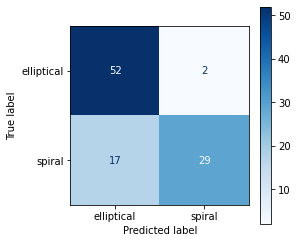

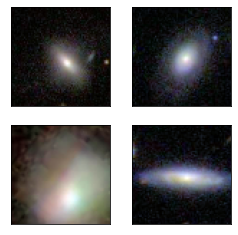

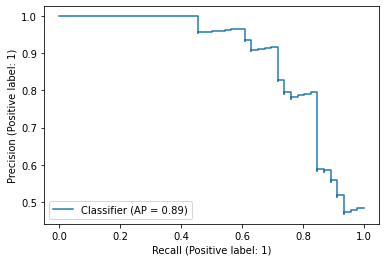

In [14]:
model = keras.models.load_model('best_cnn')
evaluate_model(model)

### Adjust the CNN!

Here's the CNN code all in one cell - try changing some of the hyperparameters!

In [ ]:
model = keras.Sequential([
    keras.Input(shape=images.shape[1:]),
    
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
            
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
    ])

model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.Accuracy()],
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    ),
    keras.callbacks.ModelCheckpoint("my_best_cnn",
        monitor='val_loss',
        verbose=0,
        save_best_only=True)
]

datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75, 1.3])

history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

model = keras.models.load_model('my_best_cnn')
evaluate_model(model)

## Classifying Light Curves with Recurrent Neural Networks

### What is a Recurrent Neural Net?
RNNs are useful in dealing with sequential data, like time series and text. A recurrent layer starts with a cell of neurons that takes in one input data point and generates a **cell state** and an output. Then, the *same* cell takes in the second data point and the *cell state from the previous input* and generates a new cell state and an output. In this way, the RNN generates a processed output sequence of the same length as the input sequence. Because the same cell is used repeatedly, this network will find the same patterns no matter where they occur in the sequence, and there are much fewer parameters than if the two sequences were fully connected. Also, this architecture can handle *variable length* sequences.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="50%"/>

from [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah

### Handling Long-Range Dependencies
RNNs can suffer from the **vanishing/exploding gradient** problem because they apply the same cell repeatedly. Imagine our cell's output is simply:
$$ h_t = f(v x_t + w h_{t-1} + b) $$
Then, the derivative with respect to $w$ is:
$$ \frac{\partial h_t}{\partial w} = f'(v x_t + w h_{t-1} + b) \left(h_{t-1} + \frac{\partial h_{t-1}}{\partial w} \right) \\
= f'(v x_t + w h_{t-1} + b) \left(h_{t-1} + f'(v x_{t-1} + w h_{t-2} + b) \left(h_{t-2} + \frac{\partial h_{t-2}}{\partial w} \right)\right) = \dots$$
so many gradients and outputs will get multiplied together - if they tend to be less than one, then the gradient will vanish, or if they tend to be greater than one, they will explode. To handle this issue, gated RNNs like LSTM (long short term memory) and GRU (gated recurrent unit) are used. We'll use GRU cells because they have fewer parameters than LSTM.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png" width="75%" />

from [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah

The hidden state is a vector of multiple numbers, and the cell has gates that depend on the previous hidden state $h_{t-1}$ and the current input (could also be a vector of multiple features at the same time) $x_t$. The reset gate $r_t$ determines how much each element of the previous hidden state will contribute to the candidate hidden state $\tilde{h}_t$. The current hidden state is a linear combination of the previous hidden state $h_{t-1}$ and the candidate hidden state $\tilde{h}_t$, with the fractional contribution of the two being determined for each element by the update gate $z_t$. (Unlike in LSTM, in GRU, the "hidden" state is also the "output".) Thus, elements of the hidden state can preserve information from long ago in the time series, and this information can be replaced with new information when needed.

### Pre-processing Light Curves
We will demonstrate RNNs on light curves from the LINEAR project, specifically a subset of 6 thousand that are classified as various types of periodic variable stars.

In [16]:
data_raw = fetch_LINEAR_sample() # raw light curves
data_cln = fetch_LINEAR_geneva() # classifications
labels = ['ab RRL', 'c RRL', 'EA', 'EB/EW', 'SX Phe']
print(data_raw.ids.size)
print(data_cln.size)

7010
6146


Not all of the light curves have classifications, so we have to do some matching between the light curve and classification data objects. We will also use the periods found by LINEAR to phase the light curves before inputting them into the RNN.

In [17]:
lcs = []
y = []
linear_id = []
periods = []
for i in tqdm(range(data_cln.size)):
    try:
        lcs.append(data_raw[data_cln['LINEARobjectID'][i]])
        y.append(data_cln['LCtype'][i])
        periods.append(10**data_cln['logP'][i])
    except KeyError:
        continue
y = np.array(y)
periods = np.array(periods)
print(y.shape)

100%|██████████| 6146/6146 [00:16<00:00, 364.27it/s]

(5204,)


`keras` expects classes to be consecutive whole numbers starting from 0, but this data set has no class 0 or 3. We adjust the `y` array until the classes are 0, 1, 2, 3, and 4.

In [18]:
print(np.unique(y))

[1 2 4 5 6]


In [19]:
y_adj = y.copy()
y_adj[y_adj > 2] -= 1
print(np.unique(y_adj))
y_adj -= 1
print(np.unique(y_adj))
n_class = np.unique(y_adj).size

[1 2 3 4 5]
[0 1 2 3 4]


In a multiclass classification problem, `keras` wants the classes to be encoded as **one-hot vectors**: we can use `to_categorical` to convert our whole numbers into one-hot encoding.

In [20]:
y_cat = keras.utils.to_categorical(y_adj)
print(y_cat)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


Our light curves have large gaps; since the periodicity of these light curves is easy to find with techniques like Lomb-Scargle, let's give our neural network phased light curves.

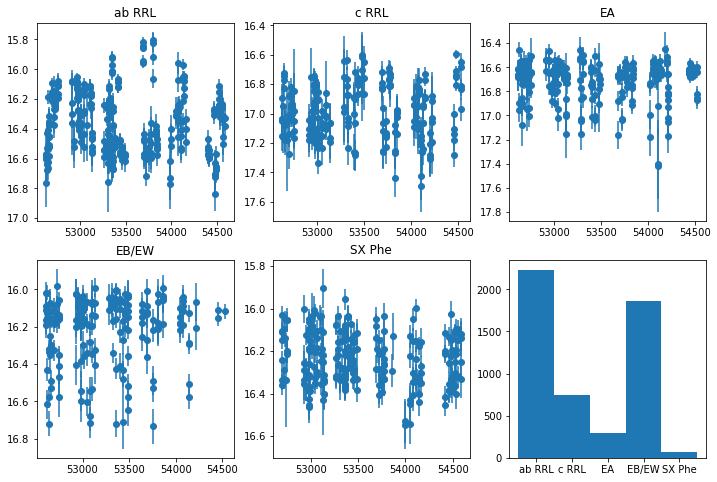

In [21]:
plt.figure(figsize=(12,8))
for i in range(5):
    j = np.nonzero(y_adj == i)[0][0]
    t, y, dy = lcs[j].T
    plt.subplot(2, 3, i+1)
    plt.errorbar(t, y, dy, marker='o', linestyle='')
    plt.gca().invert_yaxis() # because magnitudes go backwards...
    plt.title(labels[i])
plt.subplot(2, 3, 6)
plt.hist(y_adj, bins=np.arange(6)-0.5)
plt.xticks(np.arange(5), labels)
plt.show()

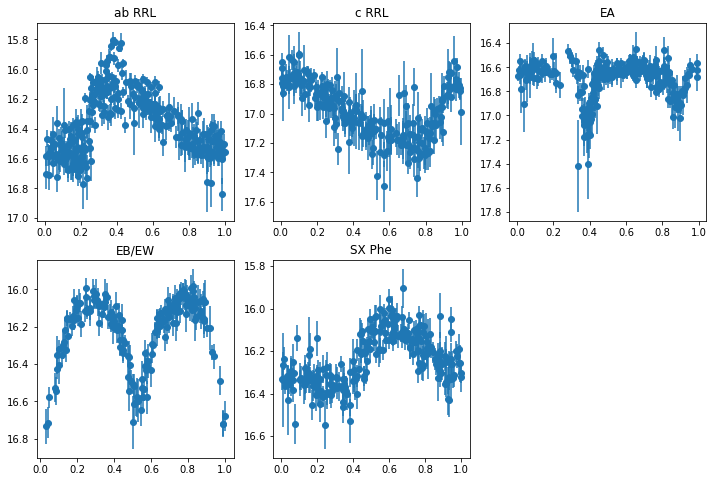

In [22]:
plt.figure(figsize=(12,8))
for i in range(5):
    j = np.nonzero(y_adj == i)[0][0]
    t, y, dy = lcs[j].T
    plt.subplot(2, 3, i+1)
    plt.errorbar((t % periods[j])/periods[j], y, dy, marker='o', linestyle='')
    plt.gca().invert_yaxis()
    plt.title(labels[i])
plt.show()

Astronomical light curves are often difficult for RNNs to deal with, due to uneven sampling and significant noise. We'll adopt a similar approach to SuperRAENN ([Villar et al. 2020](https://ui.adsabs.harvard.edu/link_gateway/2020ApJ...905...94V/PUB_HTML)) and interpolate our light curves onto a regular grid using Gaussian Processes:

  0%|          | 0/5204 [00:00<?, ?it/s]

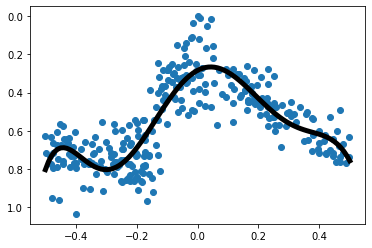

100%|██████████| 5204/5204 [00:32<00:00, 158.60it/s]


In [23]:
nt = 100
phase_arr = np.linspace(-0.5, 0.5, nt)

processed_lcs = []
interpolated_lcs = np.zeros((len(lcs), nt, 1))
for i in tqdm(range(len(lcs))):
    lc = lcs[i]
    
    processed_lc = np.zeros((lc.shape[0], 2))
    
    phase = (lc[:, 0] % periods[i])/periods[i]
    # index of peak (minimum magnitude)
    j = np.argmin(lc[:, 1])
    # first feature is phase relative to peak
    phase -= phase[j]
    phase[phase < -0.5] += 1
    phase[phase > 0.5] -= 1
    processed_lc[:, 0] = phase
    # second feature is difference in magnitude from peak
    processed_lc[:, 1] = lc[:, 1] - lc[j, 1]
    
    processed_lcs.append(processed_lc)
    
    gpr = GaussianProcessRegressor().fit(phase.reshape(-1,1), processed_lc[:, 1])
    interpolated_lcs[i, :, 0] = gpr.predict(phase_arr.reshape(-1,1))
    
    if i == 0:
        plt.scatter(processed_lc[:, 0], processed_lc[:, 1])
        plt.plot(phase_arr, interpolated_lcs[i, :, 0], lw='5', c='k')
        plt.gca().invert_yaxis()
        plt.show()

You may be wondering, why we don't just use a 1-D CNN if we have regularly sampled light curves with the same number of data points? Indeed, this is the approach that ParSNIP ([Boone 2021](https://ui.adsabs.harvard.edu/link_gateway/2021AJ....162..275B/PUB_HTML)) takes. RNNs can be useful in astronomy because they can be used on incomplete sequences that are currently being observed, and then updated when new data points come in. Astronomers are *very* interested in early transient detection! There are approaches to handle irregularly sampled time series: for example, [Naul et al. 2018](https://ui.adsabs.harvard.edu/link_gateway/2018NatAs...2..151N/PUB_HTML) add the $\Delta t$ between time points as a feature. 

In [24]:
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(interpolated_lcs, y_cat, [0.8, 0.1, 0.1], random_state=0)

We will use a first GRU with a hidden state of 16 elements that takes in our light curves and returns a sequence of hidden states of the same length (`return_sequences=True`). Then we will use a second GRU with a hidden state of 8 elements and only connect the last hidden state to the output layer. We're doing multiclass classification, so we need to use the `softmax` activation function and the `CategoricalCrossentropy` loss function.

In [25]:
model = keras.Sequential([
    layers.Input(interpolated_lcs.shape[1:]),
    layers.GRU(16, return_sequences=True),
    layers.GRU(8),
    layers.Dense(n_class, activation='softmax')
    ])

model.summary()

model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    )
]

history = model.fit(X_train,
    y_train,
    batch_size=128,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 16)           912       
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
Total params: 1,581
Trainable params: 1,581
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 8s 124ms/step - loss: 1.1082 - categorical_accuracy: 0.5698 - val_loss: 0.7150 - val_categorical_accuracy: 0.7731 - lr: 0.0100
Epoch 2/100
33/33 [==============================] - 3s 97ms/step - loss: 0.6416 - categorical_accuracy: 0.7692 - val_loss: 0.4839 - val

In the textbook, linear SVM and GMMBayes classifiers are trained on summary statistics of the light curves and photometric colors, with performance listed in Tables 10.2 and 10.3. Our classifier which uses the light curves alone obtains similar performance!

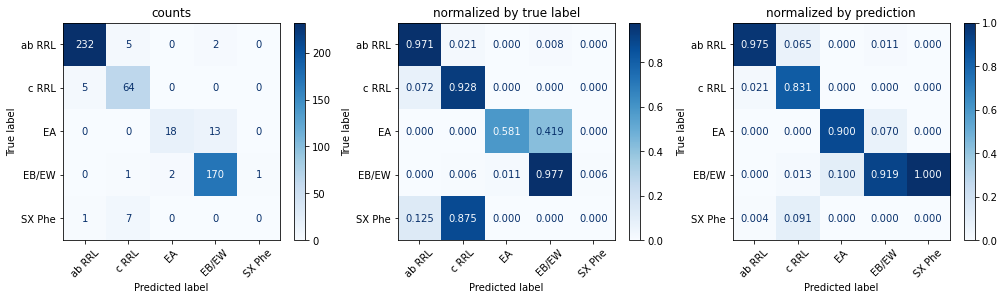

In [26]:
pred_proba = model.predict(X_test)
pred_class = np.argmax(pred_proba, axis=1)

fig = plt.figure(figsize=(17,4))
ax = plt.subplot(1,3,1)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, display_labels=labels, xticks_rotation=45)
plt.title('counts')
ax = plt.subplot(1,3,2)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='true', values_format='.3f', display_labels=labels, xticks_rotation=45)
plt.title('normalized by true label')
ax = plt.subplot(1,3,3)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='pred', values_format='.3f', display_labels=labels, xticks_rotation=45)
plt.title('normalized by prediction')
plt.show()